In [2]:
from data_extraction import load_data, build_supply_demand_curves, fetch_weather_data, find_intersection
from model import process_embedding_data, get_train_test_split, compute_baseline_mae

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast

from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors

import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
# CONFIG
root_path = r"C:\Users\azize\Documents\PHD\repos\phd-uc3m"

# Load and process AEMO Data

In [10]:
# NOTE: Only need to run once
# Process raw AEMO data into parquet table

# Data paths 
input_path_format = root_path + r"\aemo\data\raw_data\stem-bids-and-offers-{year}-{month}.csv"

# Years and months to iterate over
years = [2025]
max_month = 4
months = [f"{month:02}" for month in range(1, max_month + 1)]

# Load data
load_data(input_path_format, root_path, years, months)

Data for 2023 loaded successfully.


In [4]:
# Load processed data
selected_years = [2021, 2022, 2023, 2024, 2025]
demand_data = []
supply_data = []
for year in selected_years:

    year_demand_curves = pd.read_csv(root_path + rf"\aemo\data\processed\demand_curves_{year}.csv")
    year_supply_curves = pd.read_csv(root_path + rf"\aemo\data\processed\supply_curves_{year}.csv")

    year_demand_curves["raw_curve"] = year_demand_curves["raw_curve"].apply(ast.literal_eval)
    year_demand_curves["cross_point"] = year_demand_curves["cross_point"].apply(ast.literal_eval)
    year_supply_curves["raw_curve"] = year_supply_curves["raw_curve"].apply(ast.literal_eval)
    year_supply_curves["cross_point"] = year_supply_curves["cross_point"].apply(ast.literal_eval)

    demand_data.append(year_demand_curves)
    supply_data.append(year_supply_curves)

    print("Loaded data for year", year)
    print(year, "demand curves:", len(year_demand_curves))
    print(year, "supply curves:", len(year_supply_curves))

demand_curves = pd.concat(demand_data, ignore_index=True)
supply_curves = pd.concat(supply_data, ignore_index=True)

Loaded data for year 2021
2021 demand curves: 17520
2021 supply curves: 17520
Loaded data for year 2022
2022 demand curves: 17520
2022 supply curves: 17520
Loaded data for year 2023
2023 demand curves: 17520
2023 supply curves: 17520
Loaded data for year 2024
2024 demand curves: 17568
2024 supply curves: 17568
Loaded data for year 2025
2025 demand curves: 5472
2025 supply curves: 5472


In [15]:
result_demand = np.fromiter(
    (y for lista in demand_curves["raw_curve"] for (_, y) in lista),
    dtype=float
)
rounded_demand = np.round(result_demand, 1)
unique_demand = np.unique(rounded_demand)

result_supply = np.fromiter(
    (y for lista in supply_curves["raw_curve"] for (_, y) in lista),
    dtype=float
)
rounded_supply = np.round(result_supply, 1)
unique_supply = np.unique(rounded_supply)

In [16]:
print(unique_demand.size)
unique_demand

6155


array([-1000. ,  -999.9,  -999.8, ...,  1092. ,  1100. ,  1102. ])

In [17]:
print(unique_supply.size)
unique_supply

5441


array([-1000. ,  -998.2,  -990.8, ...,  1099.8,  1100. ,  1102. ])

In [23]:
joint_unique = np.unique(np.concatenate([unique_demand, unique_supply]))
print(joint_unique.size)
joint_unique

7948


array([-1000. ,  -999.9,  -999.8, ...,  1099.8,  1100. ,  1102. ])

In [31]:
joint_no_unique = np.concatenate([rounded_demand, rounded_supply])
print(joint_no_unique.size)
joint_no_unique

9715146


array([  49.8,   49.8,   45.3, ..., 1098. , 1100. , 1100. ])

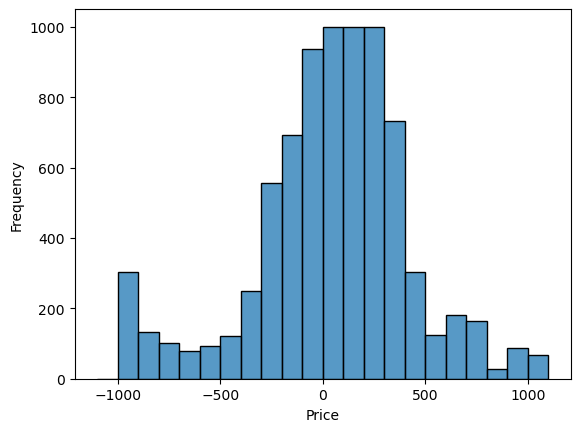

In [32]:
import seaborn as sns

bins = np.arange(-1100, 1200, 100)

sns.histplot(joint_unique, bins=bins, kde=False)

plt.title("")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

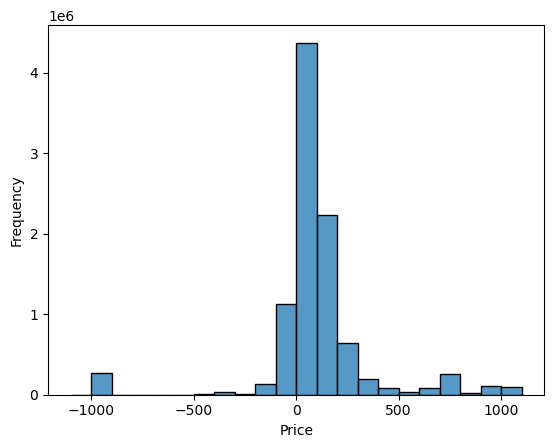

In [33]:
bins = np.arange(-1100, 1200, 100)

sns.histplot(joint_no_unique, bins=bins, kde=False)

plt.title("")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

In [36]:
np.percentile(np.abs(joint_no_unique), 80)

194.0

## Showing some results

In [66]:
cross_points = supply_curves.merge(demand_curves, on=["day", "interval", "cross_point"], how="inner", suffixes=["_supply", "_demand"])[
    ["day", "interval", "raw_curve_supply", "raw_curve_demand", "cross_point"]
]

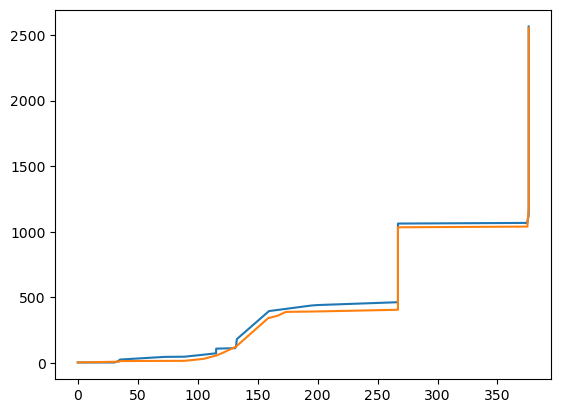

In [50]:
plt.plot(np.array(cross_points.iloc[20]["raw_curve_supply"])[:, 1], np.array(cross_points.iloc[20]["raw_curve_supply"])[:, 0])
plt.plot(np.array(cross_points.iloc[24]["raw_curve_supply"])[:, 1], np.array(cross_points.iloc[24]["raw_curve_supply"])[:, 0])

(39.221000000000004, 92.7849052631579)


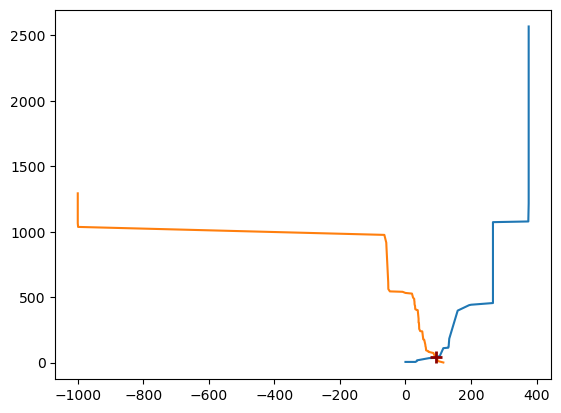

In [77]:
selected = 21
print(cross_points.iloc[selected]["cross_point"])
plt.plot(np.array(cross_points.iloc[selected]["raw_curve_supply"])[:, 1], np.array(cross_points.iloc[selected]["raw_curve_supply"])[:, 0])
plt.plot(np.array(cross_points.iloc[selected]["raw_curve_demand"])[:, 1], np.array(cross_points.iloc[selected]["raw_curve_demand"])[:, 0])
plt.plot(cross_points.iloc[selected]["cross_point"][1], cross_points.iloc[selected]["cross_point"][0], marker='+', color='darkred', markersize=8, markeredgewidth=2)

In [ ]:
all_prices = demand_curves["raw_curve"].apply(lambda l: [i[1] for i in l]).sum()

# Curve embedding

In [78]:
# Train test split
test_date = "2024-01-01"

# Curve padding
supply_curves["pad_curve"] = list(pad_sequences(supply_curves["raw_curve"].to_list(), padding='pre', dtype='float32'))
demand_curves["pad_curve"] = list(pad_sequences(demand_curves["raw_curve"].to_list(), padding='pre', dtype='float32'))

# Scale data
scaler_supply = MinMaxScaler()
scaler_demand = MinMaxScaler()
scaler_cross = MinMaxScaler()

supply_curves_train = np.stack(supply_curves[supply_curves["day"] < test_date]["pad_curve"].to_numpy())
supply_curves_test = np.stack(supply_curves[supply_curves["day"] >= test_date]["pad_curve"].to_numpy())

demand_curves_train = np.stack(demand_curves[demand_curves["day"] < test_date]["pad_curve"].to_numpy())
demand_curves_test = np.stack(demand_curves[demand_curves["day"] >= test_date]["pad_curve"].to_numpy())

cross_points_train = np.stack(supply_curves[supply_curves["day"] < test_date]["cross_point"].to_numpy())
cross_points_test = np.stack(supply_curves[supply_curves["day"] >= test_date]["cross_point"].to_numpy())

# Transform columns
supply_curves_train_scaled = scaler_supply.fit_transform(supply_curves_train.reshape(-1, 2)).reshape(supply_curves_train.shape)
demand_curves_train_scaled = scaler_demand.fit_transform(demand_curves_train.reshape(-1, 2)).reshape(demand_curves_train.shape)
cross_points_train_scaled = scaler_cross.fit_transform(cross_points_train)

supply_curves_test_scaled = scaler_supply.transform(demand_curves_test.reshape(-1, 2)).reshape(demand_curves_test.shape)
demand_curves_test_scaled = scaler_demand.transform(supply_curves_test.reshape(-1, 2)).reshape(supply_curves_test.shape)
cross_points_test_scaled = scaler_cross.transform(cross_points_test)

In [88]:
# Building embedding NN
latent_dim = 48
lstm_neurons = 64
n_in_supply = supply_curves_train_scaled.shape[1]
n_in_demand = demand_curves_train_scaled.shape[1]

input_curve_supply = Input(shape=(n_in_supply, 2))
layer_supply = LSTM(lstm_neurons, activation='tanh', return_sequences=False)(input_curve_supply)
latent_space_supply = Dense(latent_dim, activation='tanh', name='latent_space_supply')(layer_supply)
encoder_supply = Model(inputs=input_curve_supply, outputs=latent_space_supply, name='encoder_supply')

input_curve_demand = Input(shape=(n_in_demand, 2))
layer_demand = LSTM(lstm_neurons, activation='tanh', return_sequences=False)(input_curve_demand)
latent_space_demand = Dense(latent_dim, activation='tanh', name='latent_space_demand')(layer_demand)
encoder_demand = Model(inputs=input_curve_demand, outputs=latent_space_demand, name='encoder_demand')

both_curves = Concatenate()([latent_space_supply, latent_space_demand])
both_curves = Dense(16, activation='relu')(both_curves)
price_quantity = Dense(2)(both_curves)

def mae_price(y_true, y_pred):
    return tf.keras.metrics.mean_absolute_error(y_true[:, 0], y_pred[:, 0])

def mae_quantity(y_true, y_pred):
    return tf.keras.metrics.mean_absolute_error(y_true[:, 1], y_pred[:, 1])

price_quantity_model = Model(inputs=[input_curve_supply, input_curve_demand], outputs=price_quantity)
price_quantity_model.compile(optimizer='adam', loss='mae', metrics=[mae_price, mae_quantity])

In [89]:
# Fit embedding
history = price_quantity_model.fit(
    [supply_curves_train_scaled, demand_curves_train_scaled], 
    cross_points_train_scaled,
    epochs=35, 
    batch_size=128, 
    validation_split=0.1,
)

Epoch 1/50
370/370 [==============================] - 46s 119ms/step - loss: 0.0651 - mae_price: 0.1010 - mae_quantity: 0.0291 - val_loss: 0.0674 - val_mae_price: 0.0967 - val_mae_quantity: 0.0381
Epoch 2/50
370/370 [==============================] - 44s 120ms/step - loss: 0.0594 - mae_price: 0.0958 - mae_quantity: 0.0229 - val_loss: 0.0664 - val_mae_price: 0.0967 - val_mae_quantity: 0.0358
Epoch 3/50
370/370 [==============================] - 45s 123ms/step - loss: 0.0580 - mae_price: 0.0931 - mae_quantity: 0.0230 - val_loss: 0.0721 - val_mae_price: 0.1026 - val_mae_quantity: 0.0414
Epoch 4/50
370/370 [==============================] - 43s 115ms/step - loss: 0.0574 - mae_price: 0.0925 - mae_quantity: 0.0224 - val_loss: 0.0805 - val_mae_price: 0.1212 - val_mae_quantity: 0.0394
Epoch 5/50
370/370 [==============================] - 45s 121ms/step - loss: 0.0565 - mae_price: 0.0910 - mae_quantity: 0.0220 - val_loss: 0.0650 - val_mae_price: 0.0881 - val_mae_quantity: 0.0417
Epoch 6/50
370/

   MAE Price: 0.0661 (Baseline: 0.0939 --- -29.61%)
MAE Quantity: 0.0249 (Baseline: 0.0259 --- -3.86%)


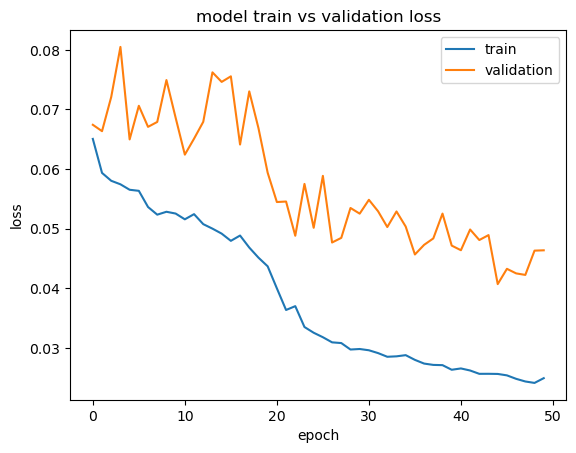

In [90]:
# Show MAE
mae_price = round(np.mean(history.history['val_mae_price'][-10:]), 4)
mae_quantity = round(np.mean(history.history['val_mae_quantity'][-10:]), 4)

baseline_price = round(compute_baseline_mae(cross_points_train_scaled[:, 0]), 4)
baseline_quantity = round(compute_baseline_mae(cross_points_train_scaled[:, 1]), 4)

mae_p_price = round(((mae_price - baseline_price) / baseline_price) * 100, 2)
mae_p_quantity = round(((mae_quantity- baseline_quantity) / baseline_quantity) * 100, 2)
print(f"   MAE Price: {mae_price} (Baseline: {baseline_price} --- {mae_p_price}%)")
print(f"MAE Quantity: {mae_quantity} (Baseline: {baseline_quantity} --- {mae_p_quantity}%)")

# Plot history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [91]:
mae_emb_test = round(np.mean(price_quantity_model.evaluate(
    [supply_curves_test_scaled, demand_curves_test_scaled], 
    cross_points_test_scaled, 
    verbose=-1
)), 4)
baseline_mae = round(compute_baseline_mae(cross_points_test_scaled, shift_days=1), 4)
baseline_p_mae = round(((mae_emb_test - baseline_mae) / baseline_mae) * 100, 2)
print(f"MAE Test: {mae_emb_test} (Baseline: {str(baseline_mae)} --- {baseline_p_mae}%)")

MAE Test: 0.1708 (Baseline: 0.0864 --- 97.69%)


In [106]:
price_quantity_model

In [ ]:
price_quantity_model.predict()

# Model development

## Load supply and demand data

In [107]:
# Generate embeddings
supply_curves_train_emb = encoder_supply.predict(supply_curves_train_scaled)
supply_curves_test_emb = encoder_supply.predict(supply_curves_test_scaled)
demand_curves_train_emb = encoder_demand.predict(demand_curves_train_scaled)
demand_curves_test_emb = encoder_demand.predict(demand_curves_test_scaled)

720/720 [==============================] - 8s 10ms/step


In [ ]:
# CONFIG
embeddings_columns = [f"X0_{i + 1}" for i in range(latent_dim)]

In [123]:
# Process supply curves data
# Create train dataframe
supply_train_data = np.hstack((
    supply_curves_train_emb,
    supply_curves[supply_curves["day"] < test_date]["day"].values.reshape(-1, 1), 
    supply_curves[supply_curves["day"] < test_date]["interval"].values.reshape(-1, 1),
))

# Create test dataframe
supply_test_data = np.hstack((
    supply_curves_test_emb,
    supply_curves[supply_curves["day"] >= test_date]["day"].values.reshape(-1, 1), 
    supply_curves[supply_curves["day"] >= test_date]["interval"].values.reshape(-1, 1),
))

# Process test and train dataframes
supply_data_columns = embeddings_columns + ["date", "interval"]
supply_train_data = pd.DataFrame(supply_train_data, columns=(supply_data_columns))
supply_test_data = pd.DataFrame(supply_test_data, columns=(supply_data_columns))
supply_data = pd.concat([supply_train_data, supply_test_data], ignore_index=True)

# Process data
supply_data = process_embedding_data(supply_data, embeddings_columns, latent_dim)


# Process demmand curves data
# Create train dataframe
demand_train_data = np.hstack((
    supply_curves_train_emb,
    demand_curves[demand_curves["day"] < test_date]["day"].values.reshape(-1, 1), 
    demand_curves[demand_curves["day"] < test_date]["interval"].values.reshape(-1, 1),
))

# Create test dataframe
demand_test_data = np.hstack((
    supply_curves_test_emb,
    demand_curves[demand_curves["day"] >= test_date]["day"].values.reshape(-1, 1), 
    demand_curves[demand_curves["day"] >= test_date]["interval"].values.reshape(-1, 1),
))

# Process test and train dataframes
demand_data_columns = embeddings_columns + ["date", "interval"]
demand_train_data = pd.DataFrame(demand_train_data, columns=(supply_data_columns))
demand_test_data = pd.DataFrame(demand_test_data, columns=(supply_data_columns))
demand_data = pd.concat([demand_train_data, demand_test_data], ignore_index=True)

# Process data
demand_data = process_embedding_data(demand_data, embeddings_columns, latent_dim)

In [ ]:
# Save processed data
supply_data.to_csv(root_path + r"\aemo\data\processed\supply_data_emb.csv", index=False)
demand_data.to_csv(root_path + r"\aemo\data\processed\demand_data_emb.csv", index=False)

## LSTM with sequential time features

In [ ]:
supply_data = pd.read_csv(root_path + r"\aemo\data\processed\supply_data_emb.csv")
demand_data = pd.read_csv(root_path + r"\aemo\data\processed\demand_data_emb.csv")

In [125]:
from numpy.lib.stride_tricks import sliding_window_view

In [139]:
latent_dim = 48
embeddings_columns = [f"X0_{i + 1}" for i in range(latent_dim)]
feature_cols = [c for c in supply_data.columns if (c not in embeddings_columns) and (c != "date")]
sequence_length = 6
test_date = "2024-04-01"

supply_data_train = supply_data[supply_data["date"] < test_date].copy().dropna()
temporal_data = supply_data_train[embeddings_columns].values
explicative_data = supply_data_train[feature_cols].values
temporal_sequences = sliding_window_view(temporal_data, window_shape=(sequence_length), axis=0)

X_seq = temporal_sequences[:-1]
X_exp = explicative_data[sequence_length:]
y_train = temporal_data[sequence_length:] 

In [146]:
# Build model
lstm_input = Input(shape=(len(embeddings_columns), sequence_length), name='lstm_input')
explicative_input = Input(shape=(len(feature_cols),), name='features_input')
lstm_inner = LSTM(128, return_sequences=True)(lstm_input)
lstm_output = LSTM(64, return_sequences=False)(lstm_inner)

concat = Concatenate()([lstm_output, explicative_input])
dense_1 = Dense(128, activation='relu')(concat)
dense_2 = Dense(64, activation='relu')(dense_1)
output_layer = Dense(48, activation='linear')(dense_2)

# Compile the model
model_supply = Model(inputs=[lstm_input, explicative_input], outputs=output_layer)
model_supply.compile(optimizer='adam', loss='mae')

# Fit model
history = model_supply.fit(
    [X_seq, X_exp], y_train,
    epochs=15,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)

Epoch 1/15
704/704 [==============================] - 34s 45ms/step - loss: 0.0503 - val_loss: 0.0652
Epoch 2/15
704/704 [==============================] - 37s 52ms/step - loss: 0.0324 - val_loss: 0.0645
Epoch 3/15
704/704 [==============================] - 35s 50ms/step - loss: 0.0277 - val_loss: 0.0598
Epoch 4/15
704/704 [==============================] - 34s 48ms/step - loss: 0.0242 - val_loss: 0.0527
Epoch 5/15
704/704 [==============================] - 35s 50ms/step - loss: 0.0212 - val_loss: 0.0500
Epoch 6/15
704/704 [==============================] - 32s 45ms/step - loss: 0.0199 - val_loss: 0.0496
Epoch 7/15
704/704 [==============================] - 33s 47ms/step - loss: 0.0198 - val_loss: 0.0493
Epoch 8/15
704/704 [==============================] - 32s 46ms/step - loss: 0.0197 - val_loss: 0.0486
Epoch 9/15
704/704 [==============================] - 32s 46ms/step - loss: 0.0197 - val_loss: 0.0484
Epoch 10/15
704/704 [==============================] - 34s 48ms/step - loss: 0.019

In [147]:
def autoregressive_predict(model, temporal_seed, explicative_inputs):

    n_pred = explicative_inputs.shape[0]
    predictions = []

    current_sequence = temporal_seed.copy()

    for t in range(n_pred):
        print(t)
        lstm_input = np.expand_dims(np.transpose(current_sequence), axis=0)
        exp_input = np.expand_dims(explicative_inputs[t], axis=0)

        pred = model.predict([lstm_input, exp_input], verbose=0)
        predictions.append(pred[0])

        current_sequence = np.vstack([current_sequence[1:], pred[0]])

    return np.array(predictions)

supply_data_test = supply_data[supply_data["date"] >= test_date].copy().dropna()
temporal_test = supply_data_test[embeddings_columns].values
explicative_test = supply_data_test[feature_cols].values

seed = temporal_test[:sequence_length]

X_exp_test = explicative_test[sequence_length:]
y_true = temporal_test[sequence_length:]

y_pred = autoregressive_predict(model_supply, seed, X_exp_test)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [150]:
mae_emb_test = round(np.mean(np.abs(y_pred - y_true)), 4)
baseline_mae = round(compute_baseline_mae(y_true, shift_days=1), 4)
baseline_p_mae = round(((mae_emb_test - baseline_mae) / baseline_mae) * 100, 2)
print(f"MAE Test: {mae_emb_test} (Baseline: {str(baseline_mae)} --- {baseline_p_mae}%)")

MAE Test: 0.18410000205039978 (Baseline: 0.0562 --- 227.5%)


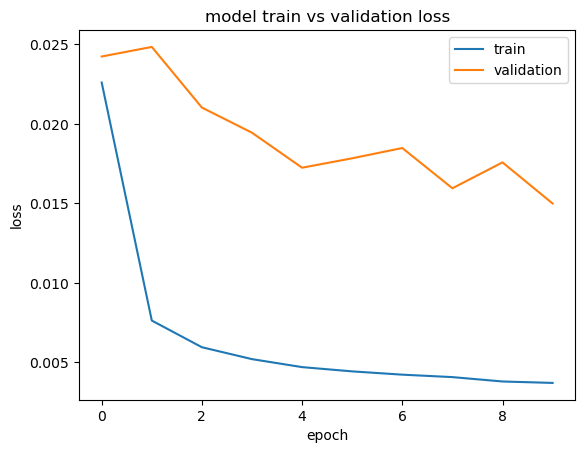

In [131]:
# Plot history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## NN with time features only

In [ ]:
supply_data = pd.read_csv(root_path + r"\aemo\data\processed\supply_data.csv")

# Target columns split
feature_cols = [c for c in supply_data.columns if (c not in embeddings_columns) and (c != "date")]
X_train, y_train, X_test, y_test = get_train_test_split(supply_data.dropna(), test_date, feature_cols, embeddings_columns)

# Model definition using Sequential
input_dim = X_train.shape[1]

model_supply = Sequential(name='model_supply')
model_supply.add(Dense(64, activation='relu', input_shape=(input_dim,), name='dense_supply_1'))
model_supply.add(Dense(48, activation='relu', name='dense_supply_2'))
model_supply.add(Dense(32, activation='tanh', name='output_supply'))

# Compile the model
model_supply.compile(optimizer='adam', loss='mae')

# Train model
history = model_supply.fit(
    X_train, y_train,
    epochs=40,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/40
422/422 [==============================] - 1s 2ms/step - loss: 0.0579 - val_loss: 0.0296
Epoch 2/40
422/422 [==============================] - 1s 1ms/step - loss: 0.0248 - val_loss: 0.0279
Epoch 3/40
422/422 [==============================] - 1s 1ms/step - loss: 0.0232 - val_loss: 0.0235
Epoch 4/40
422/422 [==============================] - 1s 2ms/step - loss: 0.0225 - val_loss: 0.0231
Epoch 5/40
422/422 [==============================] - 1s 2ms/step - loss: 0.0222 - val_loss: 0.0233
Epoch 6/40
422/422 [==============================] - 1s 2ms/step - loss: 0.0215 - val_loss: 0.0221
Epoch 7/40
422/422 [==============================] - 1s 1ms/step - loss: 0.0212 - val_loss: 0.0230
Epoch 8/40
422/422 [==============================] - 1s 1ms/step - loss: 0.0207 - val_loss: 0.0276
Epoch 9/40
422/422 [==============================] - 1s 2ms/step - loss: 0.0209 - val_loss: 0.0209
Epoch 10/40
422/422 [==============================] - 1s 2ms/step - loss: 0.0204 - val_loss: 0.0208

MAE Test: 0.0325 (Baseline: 0.0193 --- 68.39%)


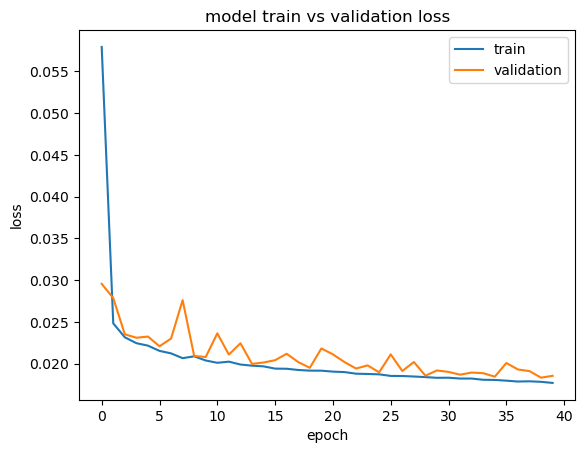

In [ ]:
mae_emb_test = round(np.mean(model_supply.evaluate(X_test, y_test, verbose=-1)), 4)
baseline_mae = round(compute_baseline_mae(y_test, shift_days=1), 4)
baseline_p_mae = round(((mae_emb_test - baseline_mae) / baseline_mae) * 100, 2)
print(f"MAE Test: {mae_emb_test} (Baseline: {str(baseline_mae)} --- {baseline_p_mae}%)")

# Plot history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Other features

In [ ]:
au_coordinates = {
    "AU-NSW": (-33.869, 151.209),  # Sydney
    "AU-QLD": (-27.471, 153.026),  # Brisbane
    "AU-TAS": (-42.887, 147.326),  # Hobart
    "AU-VIC": (-37.814, 144.963),  # Melbourne
    "AU-WA": (-31.951, 115.867),  # Perth
    "AU-SA": (-34.929, 138.601),  # Adelaide
}
supply_data = pd.read_csv(root_path + r"\aemo\data\processed\supply_data.csv")

In [ ]:
for lat, lon in 

In [ ]:
weather_data = fetch_weather_data(*au_coordinates["AU-NSW"], supply_data["date"].min(), supply_data["date"].max())
weather_daily_data = weather_data.get('daily', {})
weather_daily_data = pd.DataFrame(weather_daily_data)

In [128]:
weather_daily_data

,time,weather_code,temperature_2m_max,temperature_2m_min,temperature_2m_mean,daylight_duration,precipitation_sum,precipitation_hours,wind_speed_10m_max,shortwave_radiation_sum
0,2023-01-01,51,25.2,17.6,21.8,51701.85,0.5,5.0,20.1,26.18
1,2023-01-02,3,25.9,18.1,22.1,51668.07,0.0,0.0,24.0,30.37
2,2023-01-03,3,26.4,17.5,22.5,51631.10,0.0,0.0,19.7,29.41
3,2023-01-04,63,24.6,18.5,21.1,51591.02,10.6,16.0,27.4,18.54
4,2023-01-05,65,20.6,16.8,18.4,51547.92,57.1,16.0,35.1,22.88
...,...,...,...,...,...,...,...,...,...,...
481,2024-04-26,1,18.7,11.2,14.5,39217.09,0.0,0.0,20.6,15.96
482,2024-04-27,51,19.9,10.6,14.9,39107.66,0.1,1.0,11.9,13.98
483,2024-04-28,3,22.2,11.2,16.5,38998.88,0.0,0.0,17.7,14.89
484,2024-04-29,3,25.3,11.2,17.5,38890.86,0.0,0.0,10.1,14.09


In [ ]:
supply_data = supply_data.merge(weather_daily_data, left_on="date", right_on="time", how="left").drop(columns=["time", "weather_code"])

In [ ]:
# Target columns split
test_date = "2024-01-01"
latent_dim = 32
embeddings_columns = [f"X0_{i + 1}" for i in range(latent_dim)]

feature_cols = [c for c in supply_data.columns if (c not in embeddings_columns) and (c != "date")]
X_train, y_train, X_test, y_test = get_train_test_split(supply_data.dropna(), test_date, feature_cols, embeddings_columns)

# Scale data
scaler_supply = MinMaxScaler()
X_train_scaled = scaler_supply.fit_transform(X_train)
X_test_scaled = scaler_supply.transform(X_test)

# Model definition using Sequential
input_dim = X_train_scaled.shape[1]

model_supply = Sequential(name='model_supply')
model_supply.add(Dense(64, activation='relu', input_shape=(input_dim,), name='dense_supply_1'))
model_supply.add(Dropout(0.1))
model_supply.add(Dense(48, activation='relu', name='dense_supply_2'))
model_supply.add(Dropout(0.1))
model_supply.add(Dense(32, activation='tanh', name='output_supply'))

# Compile the model
model_supply.compile(optimizer='adam', loss='mae')

# Train model
history = model_supply.fit(
    X_train_scaled, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/20
422/422 [==============================] - 1s 2ms/step - loss: 0.0394 - val_loss: 0.0298
Epoch 2/20
422/422 [==============================] - 1s 2ms/step - loss: 0.0320 - val_loss: 0.0295
Epoch 3/20
422/422 [==============================] - 1s 2ms/step - loss: 0.0290 - val_loss: 0.0270
Epoch 4/20
422/422 [==============================] - 1s 2ms/step - loss: 0.0245 - val_loss: 0.0253
Epoch 5/20
422/422 [==============================] - 1s 2ms/step - loss: 0.0235 - val_loss: 0.0247
Epoch 6/20
422/422 [==============================] - 1s 1ms/step - loss: 0.0232 - val_loss: 0.0244
Epoch 7/20
422/422 [==============================] - 1s 2ms/step - loss: 0.0229 - val_loss: 0.0250
Epoch 8/20
422/422 [==============================] - 1s 2ms/step - loss: 0.0228 - val_loss: 0.0241
Epoch 9/20
422/422 [==============================] - 1s 2ms/step - loss: 0.0229 - val_loss: 0.0239
Epoch 10/20
422/422 [==============================] - 1s 2ms/step - loss: 0.0227 - val_loss: 0.0240

MAE Test: 0.0464 (Baseline: 0.0193 --- 140.41%)


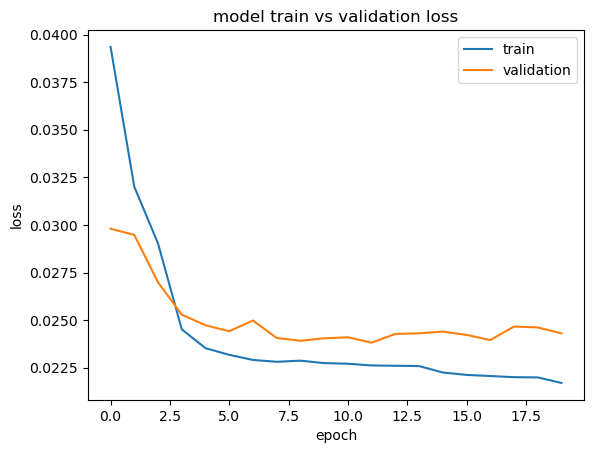

In [ ]:
mae_emb_test = round(np.mean(model_supply.evaluate(X_test_scaled, y_test, verbose=-1)), 4)
baseline_mae = round(compute_baseline_mae(y_test, shift_days=1), 4)
baseline_p_mae = round(((mae_emb_test - baseline_mae) / baseline_mae) * 100, 2)
print(f"MAE Test: {mae_emb_test} (Baseline: {str(baseline_mae)} --- {baseline_p_mae}%)")

# Plot history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# Retrieving the best curve

In [ ]:
nn = NearestNeighbors(n_neighbors=1, algorithm='auto', metric='euclidean')
nn.fit(y_train)

NearestNeighbors(metric='euclidean', n_neighbors=1)

In [151]:

distances, indices = nn.kneighbors(y_pred)


In [153]:
indices

array([[ 3094],
       [ 2031],
       [ 2847],
       ...,
       [12132],
       [11877],
       [11877]], dtype=int64)

In [157]:
supply_curves

,day,interval,raw_curve,cross_point,pad_curve
0,2021-01-01,1,"[[14.054, -8.8], [14.054, -8.8], [29.384, 19.8...","(33.721000000000004, 28.10336)","[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0..."
1,2021-01-01,2,"[[0.073, -1000.0], [0.073, -1000.0], [14.127, ...","(26.072999999999997, 13.502317025440306)","[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0..."
2,2021-01-01,3,"[[0.073, -1000.0], [0.073, -1000.0], [14.127, ...","(27.072999999999997, 15.369244618395296)","[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0..."
3,2021-01-01,4,"[[14.054, -8.8], [14.054, -8.8], [29.384, 19.8...","(27.721000000000007, 16.715299412915865)","[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0..."
4,2021-01-01,5,"[[14.054, -8.8], [14.054, -8.8], [29.384, 19.8...","(28.221000000000007, 17.64876320939336)","[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0..."
...,...,...,...,...,...
75595,2025-04-24,44,"[[1.045, -200.0], [1.045, -200.0], [8.394, 41....","(112.545, 88.77568698261015)","[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0..."
75596,2025-04-24,45,"[[1.045, -200.0], [1.045, -200.0], [8.394, 41....","(212.545, 87.70656906985306)","[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0..."
75597,2025-04-24,46,"[[1.204, -200.0], [1.204, -200.0], [8.553, 41....","(88.704, 91.37681215686274)","[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0..."
75598,2025-04-24,47,"[[1.252, -200.0], [1.252, -200.0], [8.601, 41....","(107.252, 91.27547908496733)","[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0..."


3094

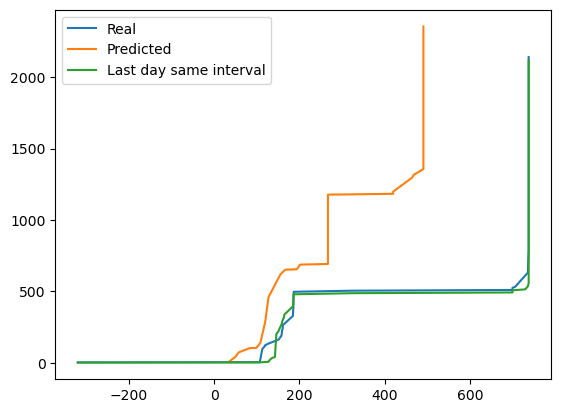

In [175]:
test_index = 650
train_index = indices[test_index][0]


plt.plot(
    np.array(supply_curves[supply_curves["day"] >= test_date].iloc[test_index]["raw_curve"])[:, 1], 
    np.array(supply_curves[supply_curves["day"] >= test_date].iloc[test_index]["raw_curve"])[:, 0],
    label="Real"
)

plt.plot(
    np.array(supply_curves.iloc[train_index]["raw_curve"])[:, 1],
    np.array(supply_curves.iloc[train_index]["raw_curve"])[:, 0],
    label="Predicted"
)

plt.plot(
    np.array(supply_curves[supply_curves["day"] >= test_date].iloc[test_index - 48]["raw_curve"])[:, 1], 
    np.array(supply_curves[supply_curves["day"] >= test_date].iloc[test_index - 48]["raw_curve"])[:, 0],
    label="Last day same interval"
)

plt.legend()

In [ ]:
train_index = 3094
test_index = 0
plt.plot(
    np.array(supply_curves.iloc[train_index]["raw_curve"])[:, 1],
    np.array(supply_curves.iloc[train_index]["raw_curve"])[:, 0]
)
plt.plot(
    np.array(supply_curves[supply_curves["day"] >= test_date].iloc[test_index]["raw_curve"])[:, 1], 
    np.array(supply_curves[supply_curves["day"] >= test_date].iloc[test_index]["raw_curve"])[:, 0]
)

,day,interval,raw_curve,cross_point,pad_curve
56928,2024-04-01,1,"[[3.177, -320.0], [3.177, -320.0], [3.33, -8.5...","(47.177, 73.32157450286026)","[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0..."
56929,2024-04-01,2,"[[3.177, -320.0], [3.177, -320.0], [3.376, -8....","(110.177, 83.77390356850994)","[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0..."
56930,2024-04-01,3,"[[3.179, -320.0], [3.179, -320.0], [3.415, -8....","(110.179, 92.45437210569327)","[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0..."
56931,2024-04-01,4,"[[3.181, -320.0], [3.181, -320.0], [3.452, -15...","(73.681, 74.37360392263689)","[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0..."
56932,2024-04-01,5,"[[3.184, -320.0], [3.184, -320.0], [3.487, -15...","(22.184, 12.619634093967418)","[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0..."
...,...,...,...,...,...
75595,2025-04-24,44,"[[1.045, -200.0], [1.045, -200.0], [8.394, 41....","(112.545, 88.77568698261015)","[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0..."
75596,2025-04-24,45,"[[1.045, -200.0], [1.045, -200.0], [8.394, 41....","(212.545, 87.70656906985306)","[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0..."
75597,2025-04-24,46,"[[1.204, -200.0], [1.204, -200.0], [8.553, 41....","(88.704, 91.37681215686274)","[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0..."
75598,2025-04-24,47,"[[1.252, -200.0], [1.252, -200.0], [8.601, 41....","(107.252, 91.27547908496733)","[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0..."
